# Introduction
**Author:** Samanyu K <br>
**Language:** Python<br>
**Accelerator:** None<br>

In [1]:
# importing

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.stattools import acf,pacf,adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Reading and Displaying Data

In [2]:
df=pd.read_csv(r'/kaggle/input/electric-production/Electric_Production.csv')
print(df.head(5),'\n',df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    397 non-null    object 
 1   Value   397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB
         DATE    Value
0  01-01-1985  72.5052
1  02-01-1985  70.6720
2  03-01-1985  62.4502
3  04-01-1985  57.4714
4  05-01-1985  55.3151 
 None


In [3]:
# Let us change the DATE data types into date_time, then split the dataset into trianing as well as testing
df['DATE']=pd.to_datetime(df['DATE'],infer_datetime_format='auto')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    397 non-null    datetime64[ns]
 1   Value   397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


/tmp/ipykernel_35/118476546.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['DATE']=pd.to_datetime(df['DATE'],infer_datetime_format='auto')


In [4]:
test_size = 0.15
split_idx = int(len(df) * (1 - test_size))

tr = df.iloc[:split_idx].copy()
te = df.iloc[split_idx:].copy()
print(tr.shape,te.shape)

(337, 2) (60, 2)


In [5]:
# Setting up date as the index
tr.set_index('DATE',inplace=True,drop=True)
te.set_index('DATE',inplace=True,drop=True)
print(tr.info(),te.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 337 entries, 1985-01-01 to 2013-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   337 non-null    float64
dtypes: float64(1)
memory usage: 5.3 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2013-02-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   60 non-null     float64
dtypes: float64(1)
memory usage: 960.0 bytes
None None


In [6]:
# Let us take a look at how our datapoints are spread
print(tr.index.min(),te.index.max())

1985-01-01 00:00:00 2018-01-01 00:00:00


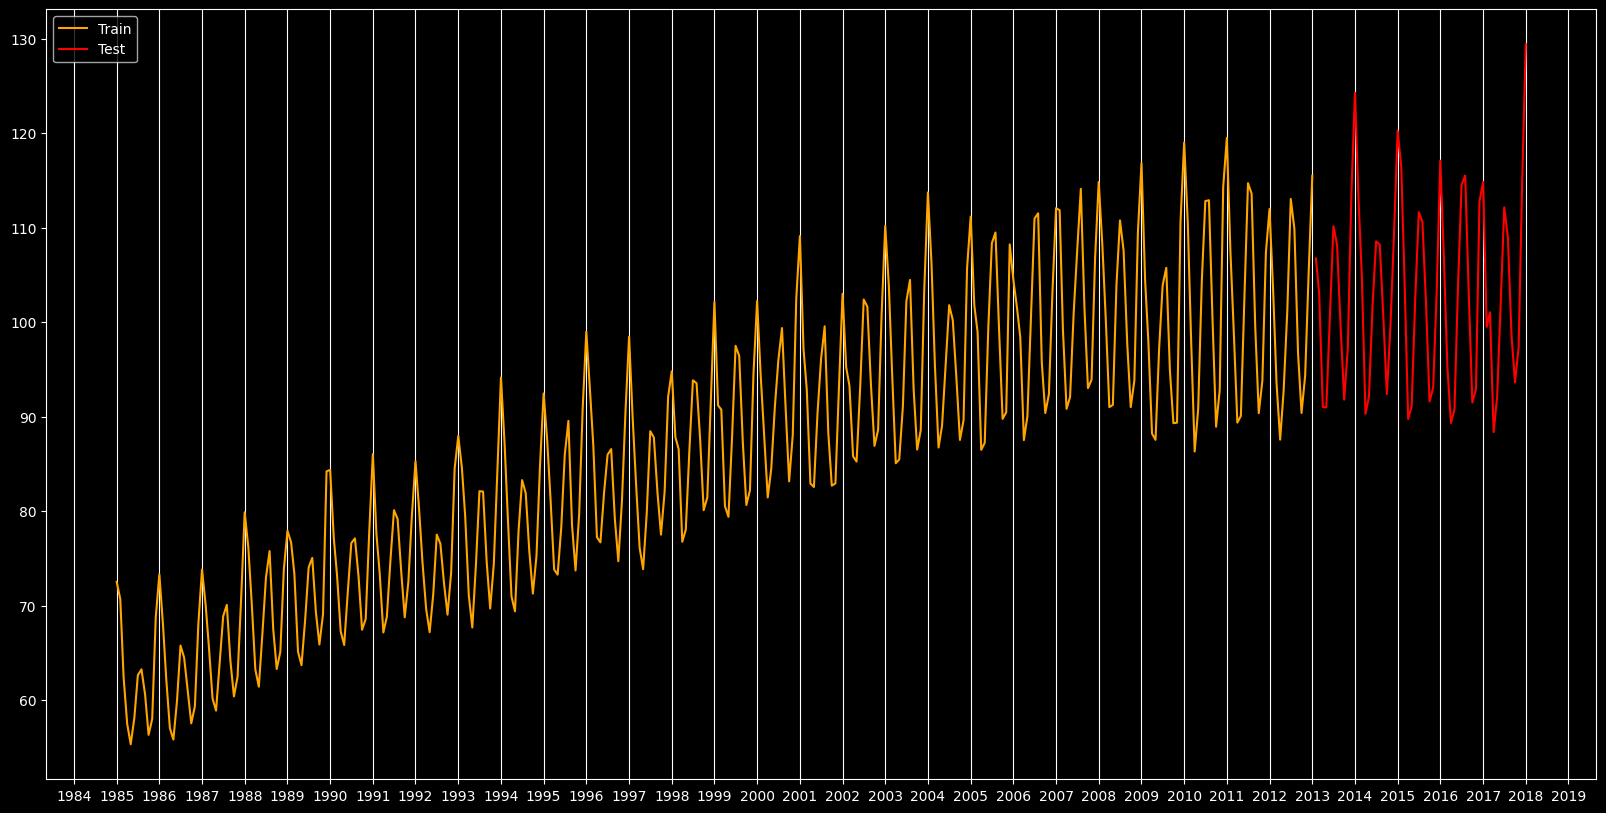

In [7]:
# It appears our data is monthly, let us plot both our training data and the one we are forcasting

plt.style.use('dark_background')
plt.figure(figsize=(20,10))
plt.plot(tr['Value'],color='orange')
plt.plot(te['Value'],color='red')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(axis='x')
plt.legend(['Train','Test'])
plt.show()

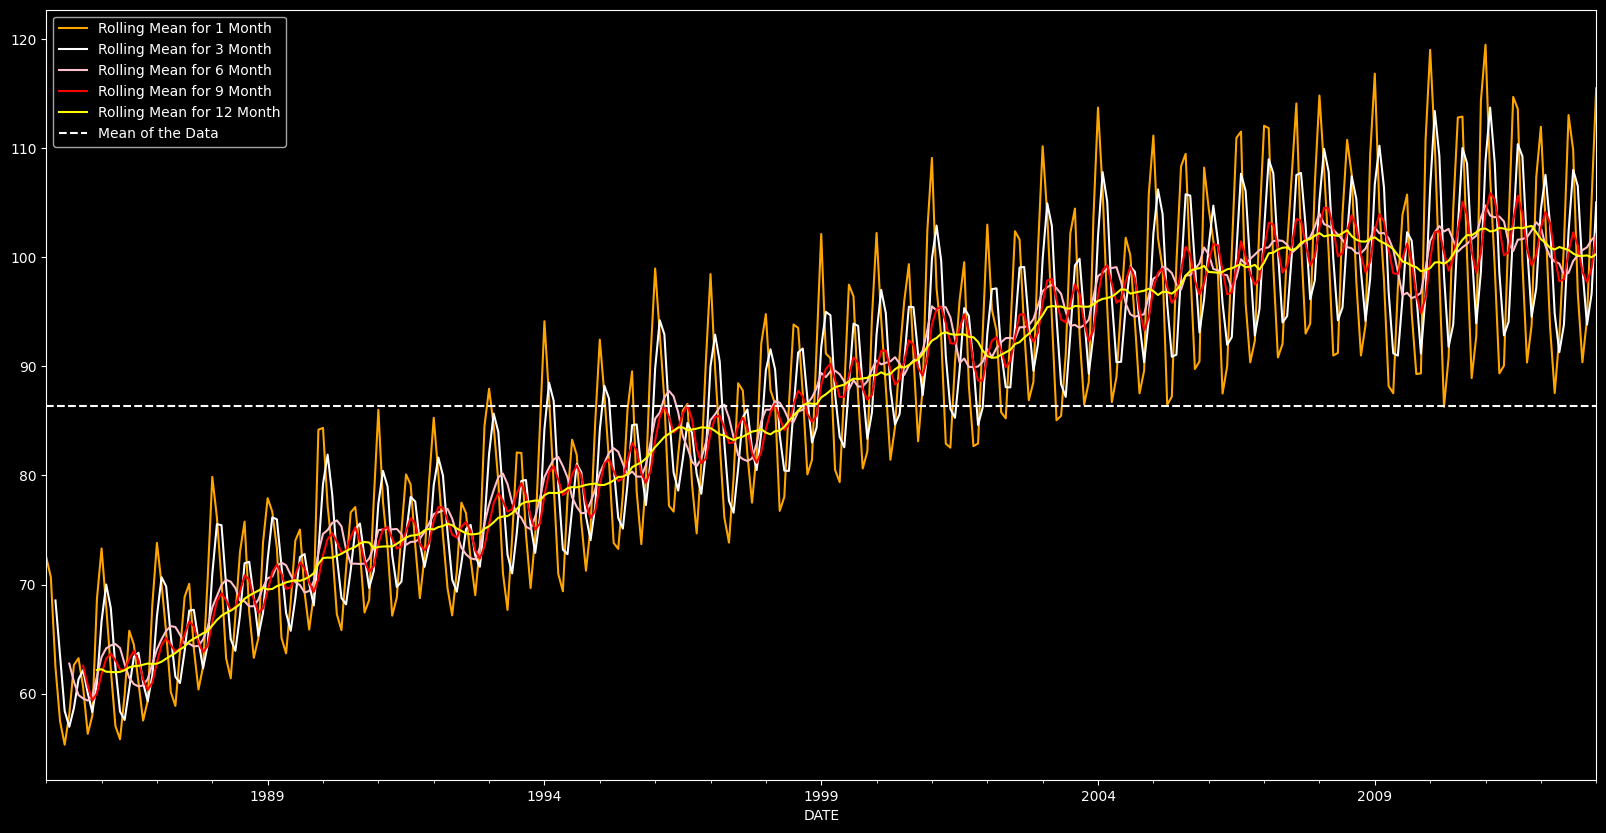

In [8]:
# Plotting rolling mean to find if it is constant

plt.figure(figsize=(20,10))
tr['Value'].rolling(1).mean().plot(label='Rolling Mean for 1 Month',color='orange')
tr['Value'].rolling(3).mean().plot(label='Rolling Mean for 3 Month',color='white')
tr['Value'].rolling(6).mean().plot(label='Rolling Mean for 6 Month',color='pink')
tr['Value'].rolling(9).mean().plot(label='Rolling Mean for 9 Month',color='red')
tr['Value'].rolling(12).mean().plot(label='Rolling Mean for 12 Month',color='yellow')
plt.axhline(tr['Value'].mean(),linestyle='--',label='Mean of the Data')
plt.legend()
plt.show()

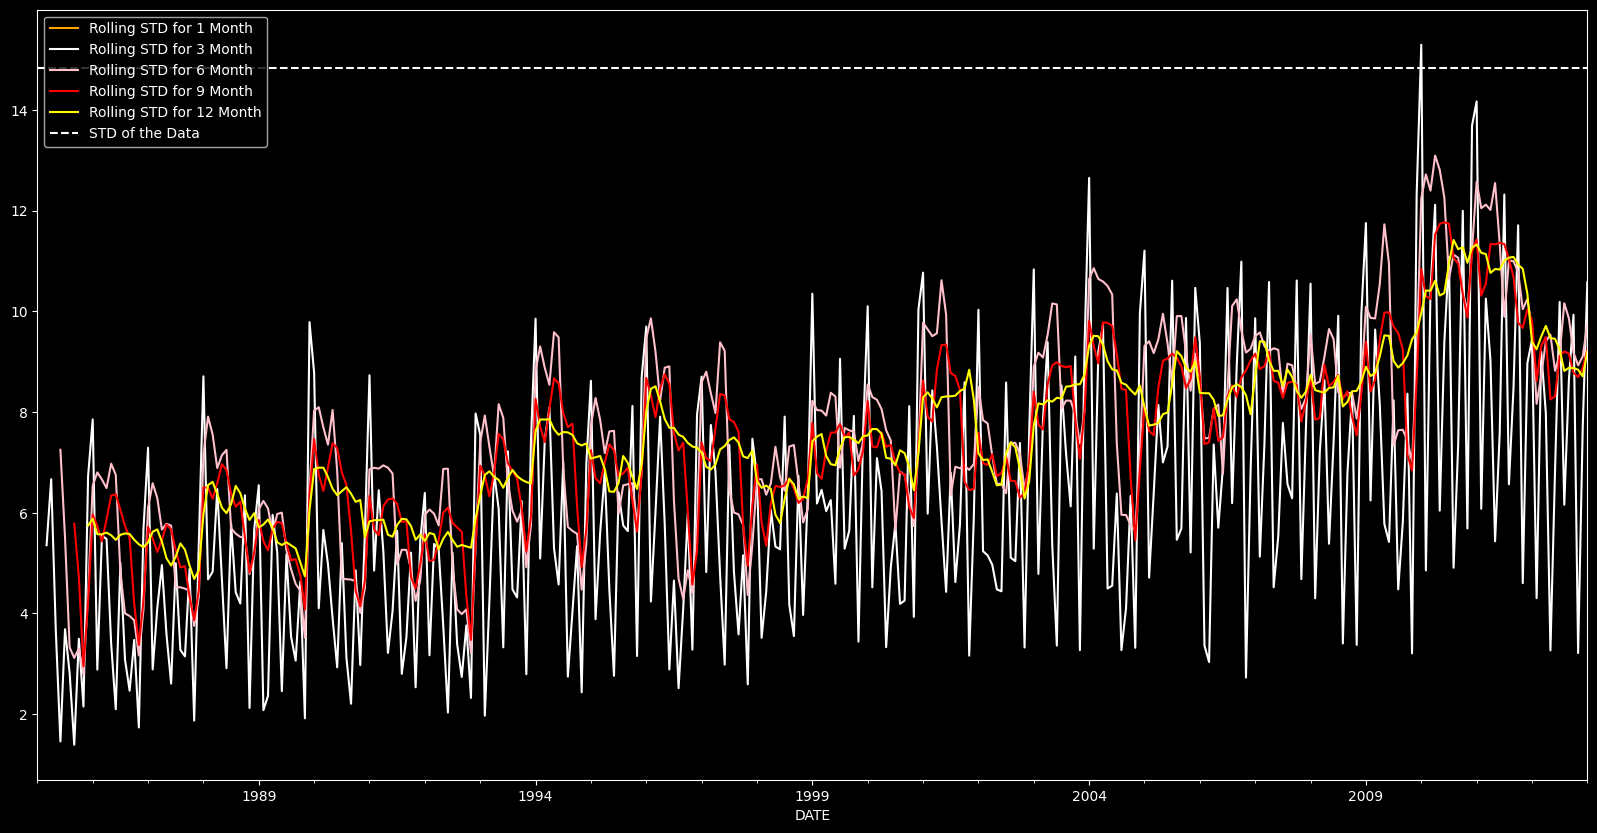

In [9]:
# the mean is not constant
# Plotting rolling std to find if it is constant

plt.figure(figsize=(20,10))
tr['Value'].rolling(1).std().plot(label='Rolling STD for 1 Month',color='orange')
tr['Value'].rolling(3).std().plot(label='Rolling STD for 3 Month',color='white')
tr['Value'].rolling(6).std().plot(label='Rolling STD for 6 Month',color='pink')
tr['Value'].rolling(9).std().plot(label='Rolling STD for 9 Month',color='red')
tr['Value'].rolling(12).std().plot(label='Rolling STD for 12 Month',color='yellow')
plt.axhline(tr['Value'].std(),linestyle='--',label='STD of the Data')
plt.legend()
plt.show()

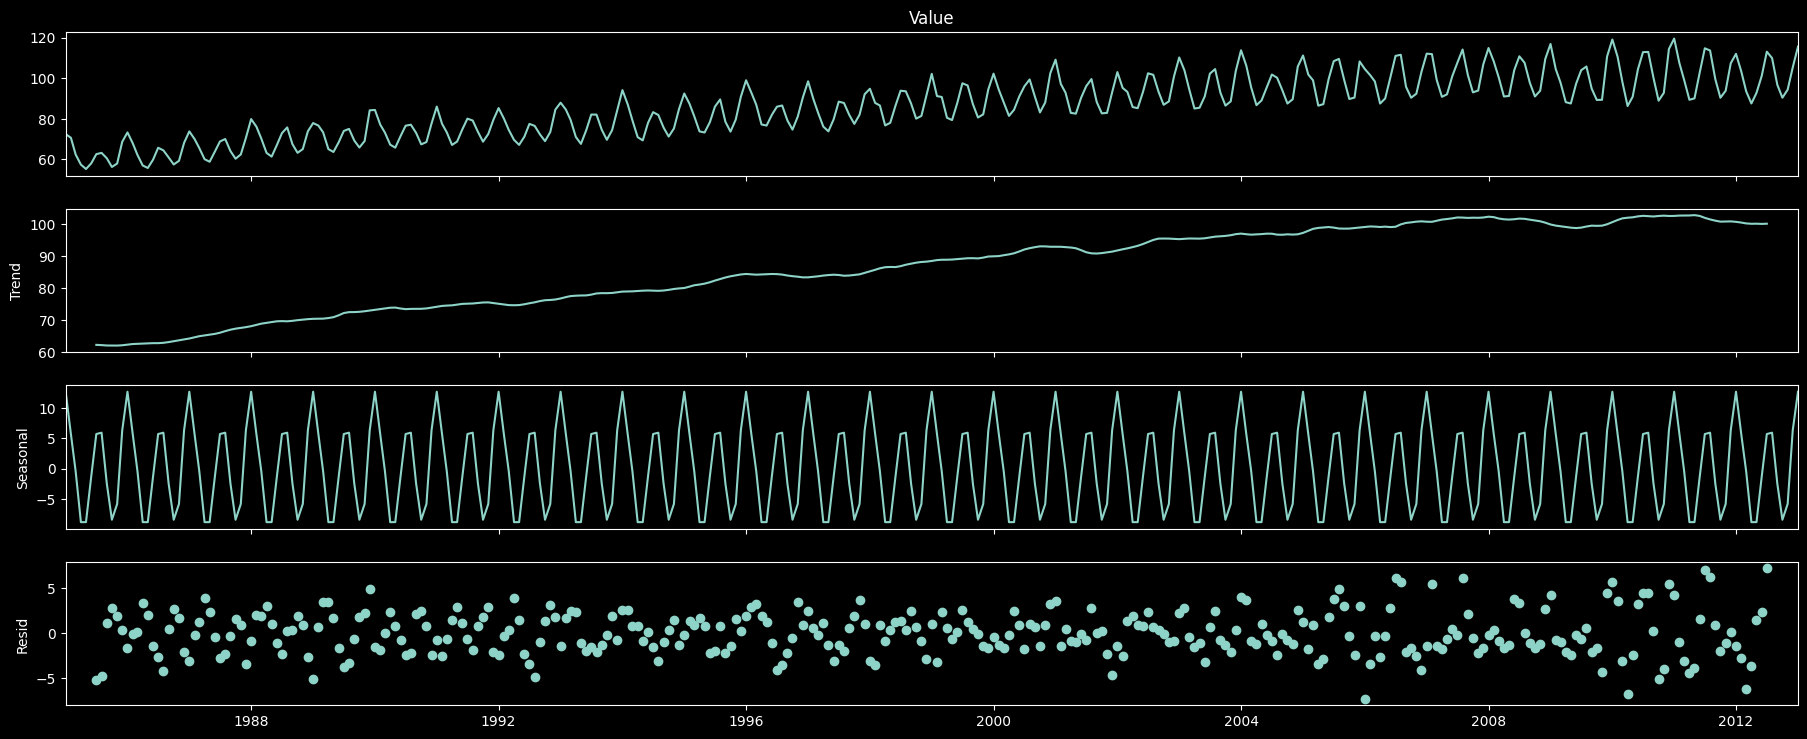

In [10]:
# Mean and Standard Deviation are not constant
# Let us look at the decomposition plots

decomposition = seasonal_decompose(tr['Value'], model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(20, 8)  
plt.show()

In [11]:
# ADF Test
adf_result = adfuller(tr['Value'])
print("===== ADF Test =====")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
if adf_result[1] <= 0.05:
    print("Stationary (likely), reject null hypothesis")
else:
    print("Not stationary, fail to reject null hypothesis")


===== ADF Test =====
ADF Statistic: -2.177961402664875
p-value: 0.21434119823056202
Not stationary, fail to reject null hypothesis


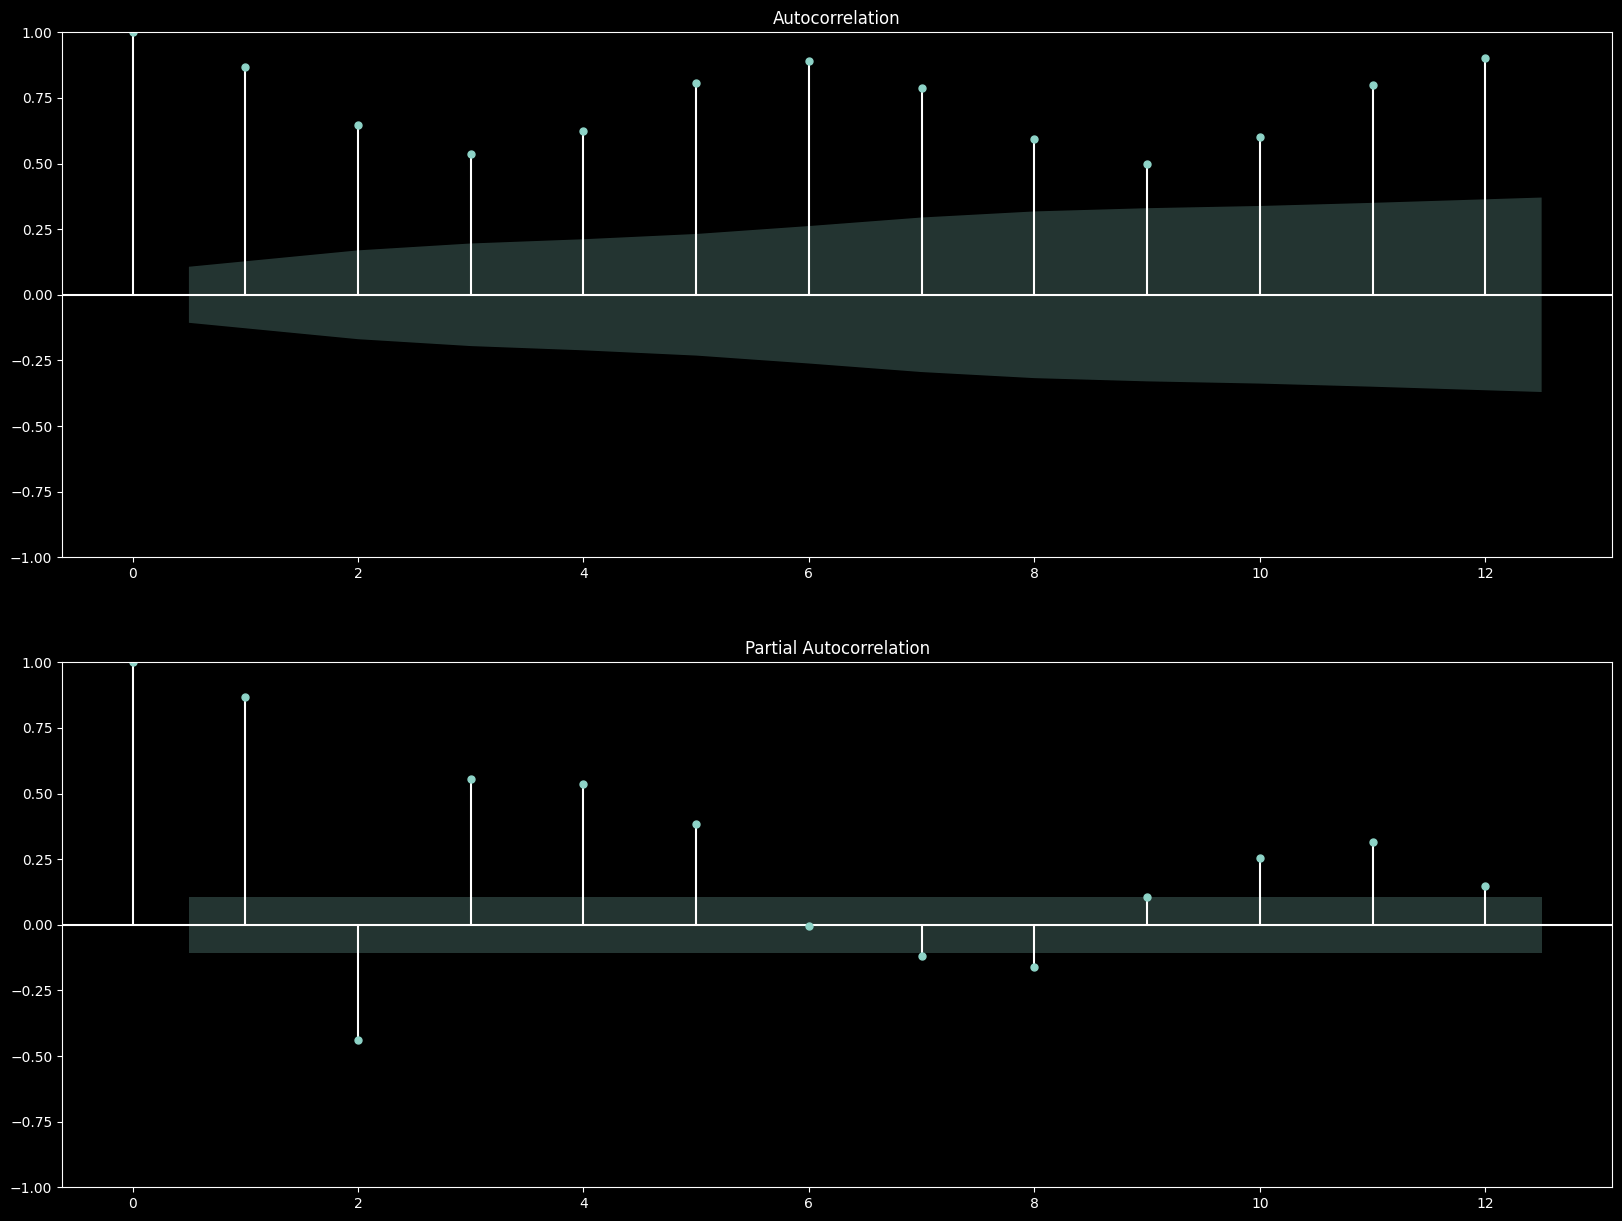

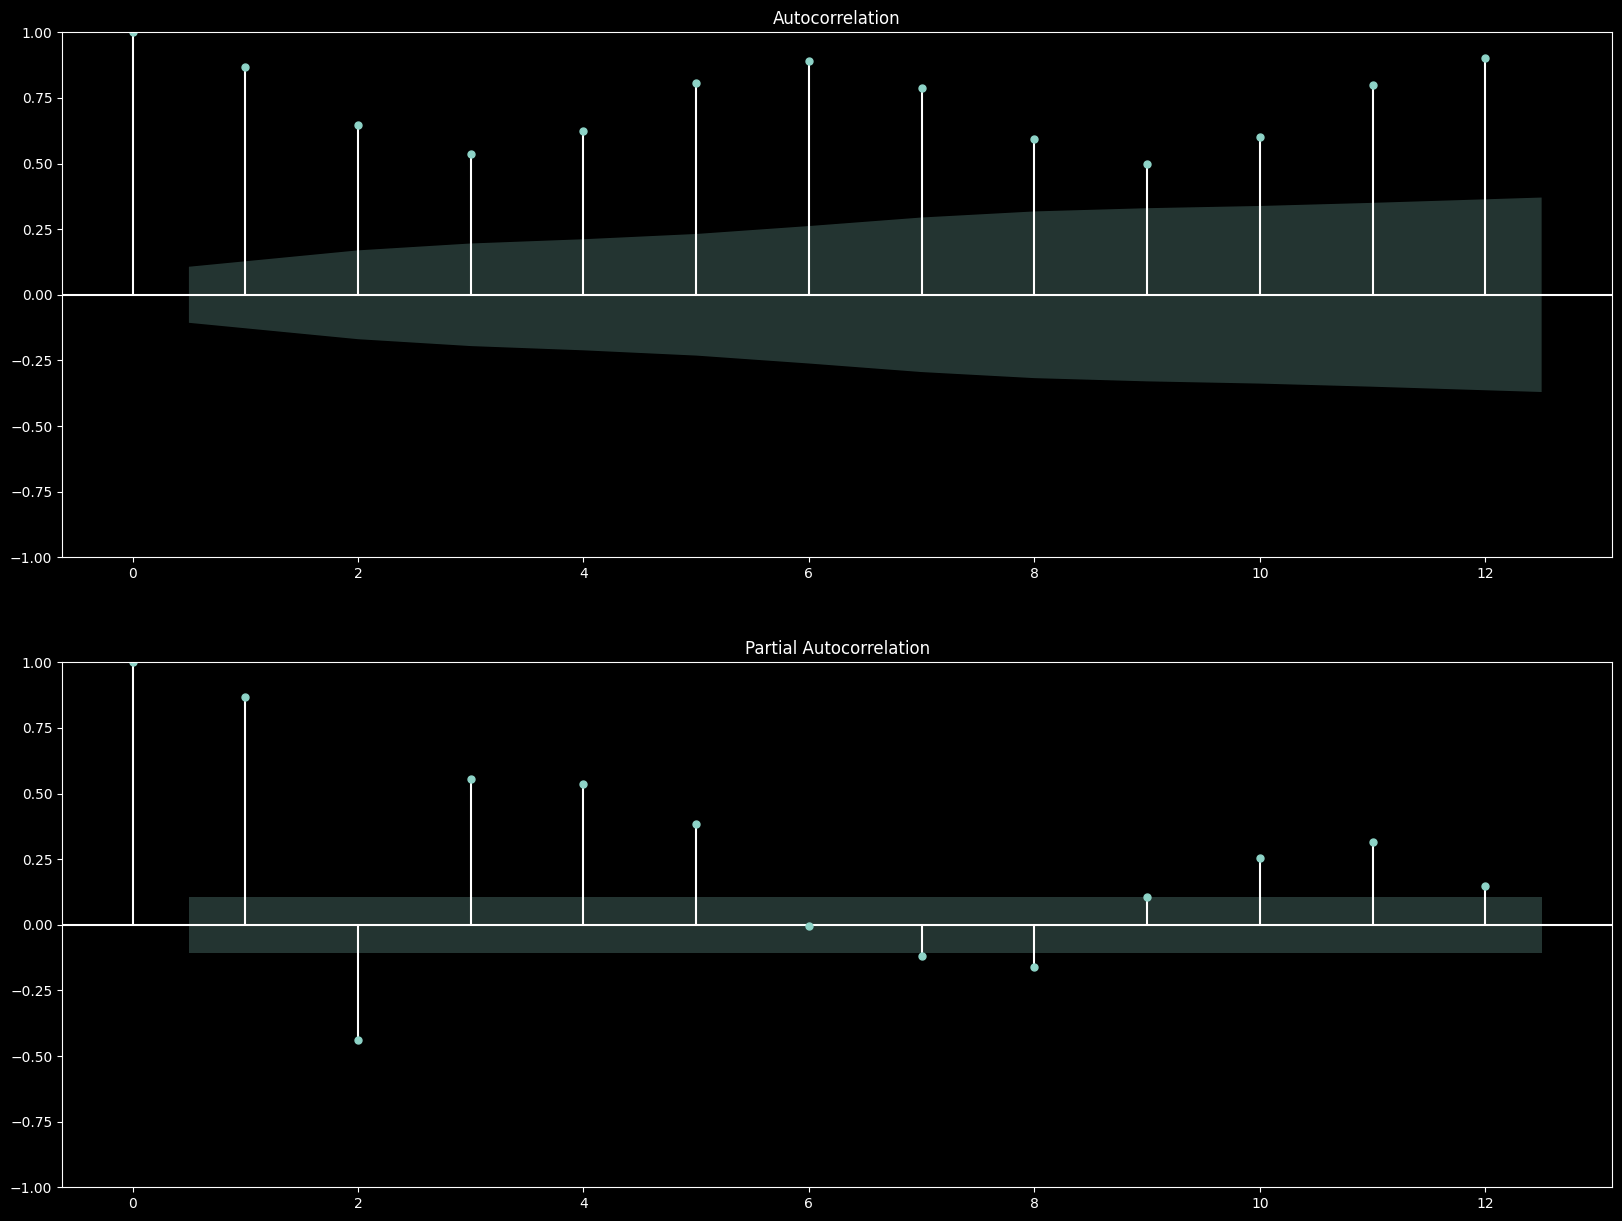

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(20, 15))
plot_acf(tr['Value'], lags=12, ax=axes[0])
plot_pacf(tr['Value'], lags=12, ax=axes[1])

# SARIMA

In [13]:
tr.index = pd.DatetimeIndex(tr.index)
tr.index.freq = pd.infer_freq(tr.index)

model = SARIMAX(endog=tr['Value'], order=(3, 1, 3), seasonal_order=(1, 1, 1, 12))
result = model.fit()
print(result.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                Value   No. Observations:                  337
Model:             SARIMAX(3, 1, 3)x(1, 1, [1], 12)   Log Likelihood                -717.169
Date:                              Mon, 26 May 2025   AIC                           1452.338
Time:                                      05:28:39   BIC                           1486.364
Sample:                                  01-01-1985   HQIC                          1465.919
                                       - 01-01-2013                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8031      0.064    -12.564      0.000      -0.928      -0.678
ar.L2         -0.30

# Forcasting

In [14]:
pred_train = result.predict(start=0, end=len(tr) - 1)
pred_train.index = tr.index

start = len(tr)
end = start + len(te) - 1
pred_test = result.predict(start=start, end=end)
pred_test.index = te.index

# Evaluation Metrics

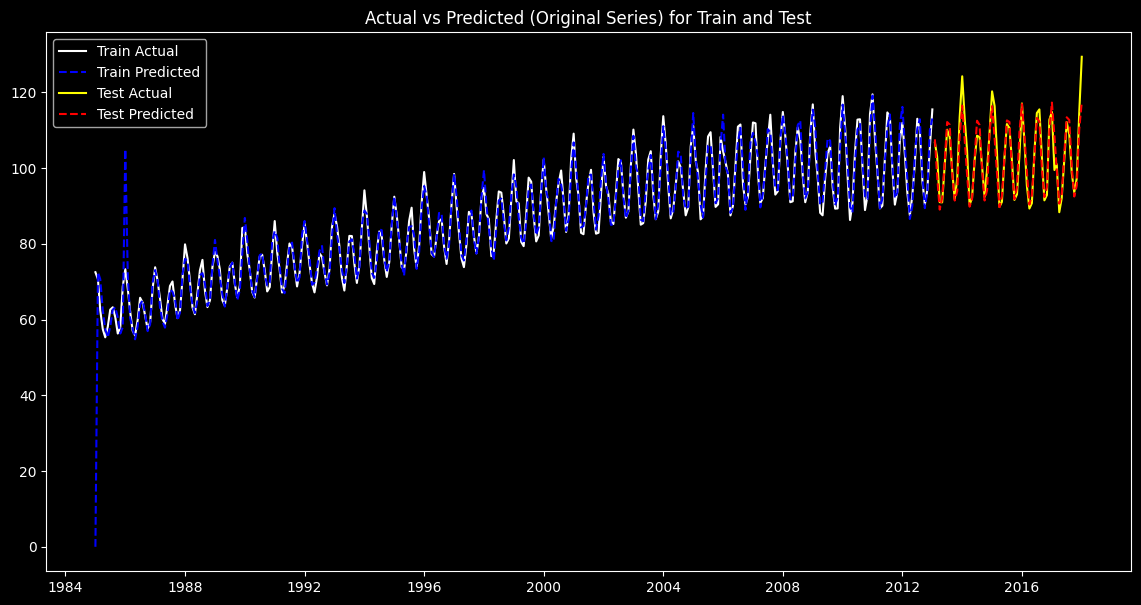

Train MSE: 24.009, MAE: 2.096
Test MSE: 13.105, MAE: 2.677
Train MAPE: 2.50%
Test MAPE: 2.51%


In [17]:
plt.figure(figsize=(14, 7))
plt.plot(tr.index, tr['Value'], label='Train Actual', color='white')
plt.plot(pred_train.index, pred_train, label='Train Predicted', color='blue', linestyle='--')
plt.plot(te.index, te['Value'], label='Test Actual', color='yellow')
plt.plot(pred_test.index, pred_test, label='Test Predicted', color='red', linestyle='--')
plt.legend()
plt.title('Actual vs Predicted (Original Series) for Train and Test')
plt.show()

mse_train = mean_squared_error(tr['Value'], pred_train)
mae_train = mean_absolute_error(tr['Value'], pred_train)
mse_test = mean_squared_error(te['Value'], pred_test)
mae_test = mean_absolute_error(te['Value'], pred_test)

print(f'Train MSE: {mse_train:.3f}, MAE: {mae_train:.3f}')
print(f'Test MSE: {mse_test:.3f}, MAE: {mae_test:.3f}')

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    non_zero = y_true != 0
    return (abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])).mean() * 100

mape_train = mean_absolute_percentage_error(tr['Value'], pred_train)
mape_test = mean_absolute_percentage_error(te['Value'], pred_test)

print(f'Train MAPE: {mape_train:.2f}%')
print(f'Test MAPE: {mape_test:.2f}%')
